In [1]:
# Load and prepare the data

import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import training_data as td
from PIL import Image
from matplotlib import pyplot as plt

def print_data_infos(data_test):
    print("Test data length: {0}".format(len(data_test.data)))
    print("Img Shape: {0}".format(data_test.data[0].shape))
    print("Number of Labels: {0}".format(data_test.no_labels))
    
data_all_test = td.DataCollection(train=False)
print_data_infos(data_all_test)

100%|██████████| 10000/10000 [00:00<00:00, 173433.01it/s]


No training data for ). Skipping
Test data length: 12817
Img Shape: torch.Size([1, 32, 32])
Number of Labels: 15


In [2]:
from torchvision.models import alexnet
from torch.nn import Conv2d
import numpy as np

def classify(imgs, model_all, model_ops, model_brckts):
    pred_all = model_all(imgs).detach().numpy()
    labels_all = np.argmax(pred_all, axis=1)
    pred_best_all = np.max(pred_all, axis=1)[None,:]
    
    pred_ops = model_ops(imgs).detach().numpy()
    labels_ops = np.argmax(pred_ops, axis=1)
    pred_best_ops = np.max(pred_ops, axis=1)[None,:]
    
    pred_brckts = model_brckts(imgs).detach().numpy()
    labels_brckts = np.argmax(pred_brckts, axis=1)
    pred_best_brckts = np.max(pred_brckts, axis=1)[None,:]
    
    best_preds = np.concatenate((pred_best_all.T, pred_best_ops.T), axis=1)
    best_preds = np.argmax(np.concatenate((best_preds, pred_best_brckts.T), axis=1), axis=1)
    labels = np.where(best_preds == 1, labels_ops, labels_all)
    labels = np.where(best_preds == 2, labels_brckts, labels)
    return labels

In [3]:
def generate_conf_matrix(labels, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes))   
    for i in range(len(labels)):
        ground_truth = data_all_test.targets[i]
        label = labels[i]
        confusion_matrix[ground_truth][label] = int(confusion_matrix[ground_truth][label]) + 1
    return confusion_matrix

def plot_conv_matrix(confusion_matrix, num_classes):
    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(confusion_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    # ... and label them with the respective list entries
    ax.set_xticklabels(td.MATH_SYMBOLS)
    ax.set_yticklabels(td.MATH_SYMBOLS)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="w")

    plt.show()

In [4]:
from classify import MathSymbolClassifier


imgs = torch.nn.utils.rnn.pad_sequence(data_all_test.data, batch_first=True, padding_value=0)
models = {'model-all-symbols.ckpt':15, 'model-no_strokes.ckpt':13, 'combined-model-BEST.ckpt':15}
classifier_ensemble = MathSymbolClassifier(num_classes=15, models=models)

#labels = classify(imgs, model_all, model_ops, model_brckts)
labels_ensemble = classifier_ensemble.classify(imgs, return_label_idxs=True)


In [5]:
models = {'combined-model-BEST.ckpt':15}
classifier_single = MathSymbolClassifier(num_classes=15, models=models)

#labels = classify(imgs, model_all, model_ops, model_brckts)
labels_single = classifier_single.classify(imgs, return_label_idxs=True)


In [6]:
models = {'model-all-symbols.ckpt':15}
classifier_all = MathSymbolClassifier(num_classes=15, models=models)

#labels = classify(imgs, model_all, model_ops, model_brckts)
labels_all = classifier_all.classify(imgs, return_label_idxs=True)

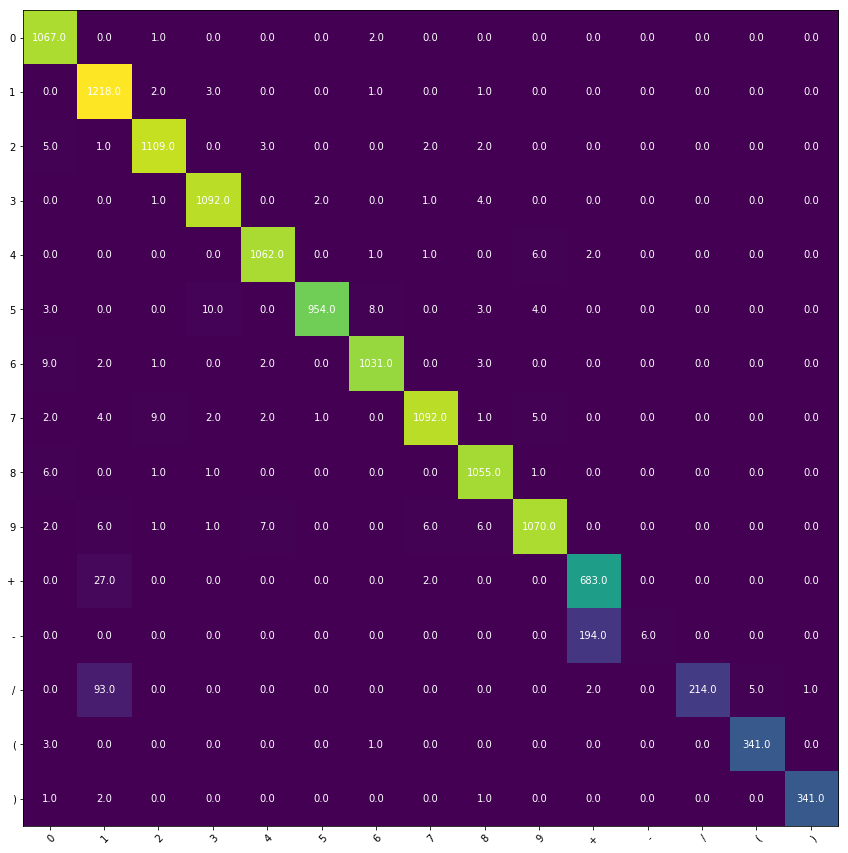

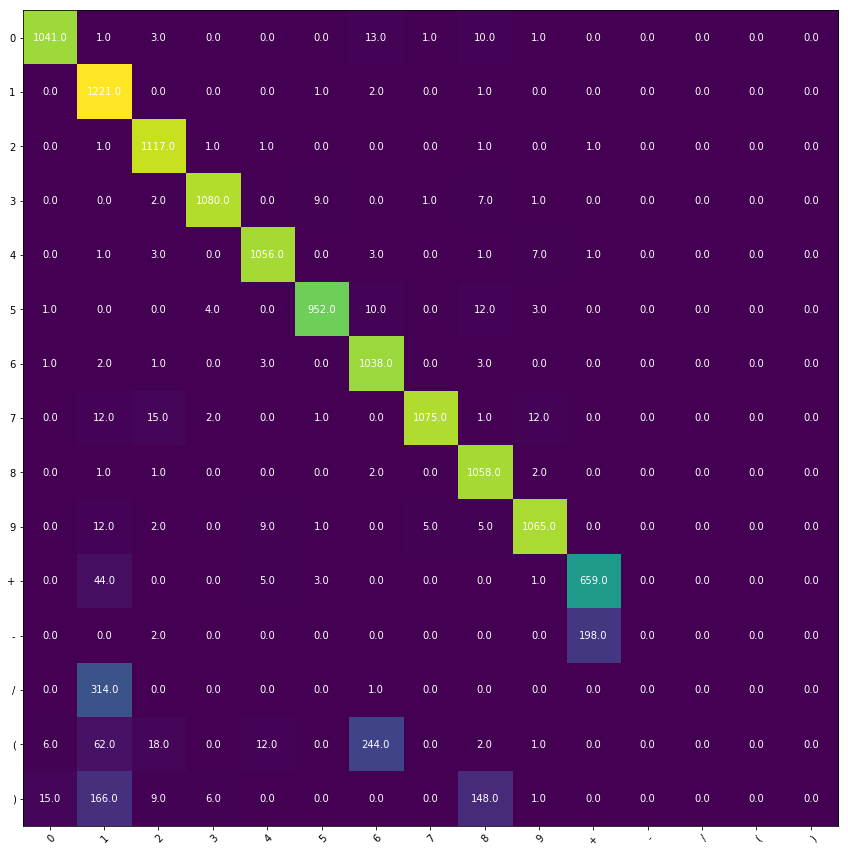

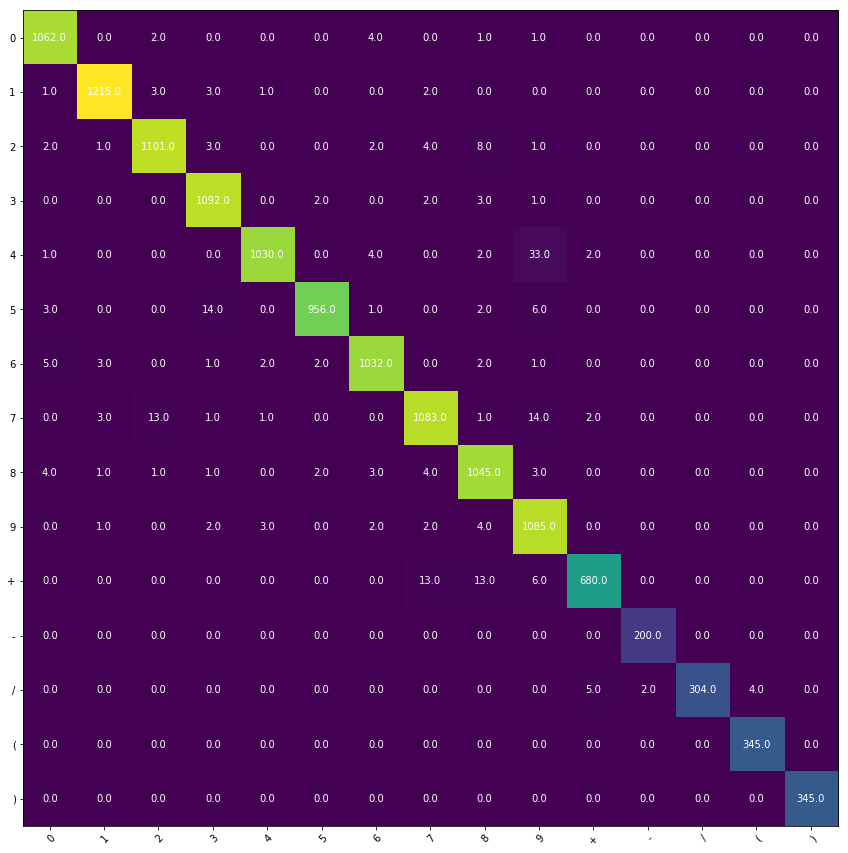

In [7]:
plot_conv_matrix(generate_conf_matrix(labels_ensemble, 15), 15)
plot_conv_matrix(generate_conf_matrix(labels_single, 15), 15)
plot_conv_matrix(generate_conf_matrix(labels_all, 15), 15)